In [1]:
import sys

sys.path.append('./library')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [31]:
import pandas as pd
import pickle

pd.options.mode.chained_assignment = None  # Disable the warning

from metrics import TestMetricsCalculator, RankingMetricsEvaluator
from rating import get_explicit_rating, split_matrix_csr, sanity_check_explicit_split, sanity_check_explicit_matrix
from k_tuner import KTuner


# Feature selection

The first dataset that is necessary for our purposes is **review** dataset since:
- it contains the information about explicit ratings (the mean of the field **stars** for pairs of users and items, check the chapter **Feature engineering** for more details)
- it contains the information for implicit rating (check the chapter **Feature engineering** for more details)
- it already contains only those users who provided at least one review and those items that received at least one estimation

In [5]:
PATH = '../../eda/dataset_samples/df_movie_lens.parquet'

The sampling approach can be checked in `eda/movie-lens.ipynb`

In [6]:
review_df = pd.read_parquet(PATH)
review_df

,user_id,movie_id,Rating,Date,YearMonth
0,5621,358,1,2000-05-23,2000-05
1,5112,2450,1,2000-06-30,2000-06
2,203,147,1,2000-12-16,2000-12
3,4387,1007,1,2000-08-05,2000-08
4,5980,2414,1,2000-04-28,2000-04
...,...,...,...,...,...
9941,1041,2186,5,2000-11-23,2000-11
9942,3842,1963,5,2000-08-10,2000-08
9943,1324,1213,5,2000-11-21,2000-11
9944,3580,353,5,2000-08-19,2000-08


In [7]:
review_df['timestamp'] = pd.to_datetime(review_df["Date"]).astype("int64") // 10 ** 9
review_df

,user_id,movie_id,Rating,Date,YearMonth,timestamp
0,5621,358,1,2000-05-23,2000-05,959040000
1,5112,2450,1,2000-06-30,2000-06,962323200
2,203,147,1,2000-12-16,2000-12,976924800
3,4387,1007,1,2000-08-05,2000-08,965433600
4,5980,2414,1,2000-04-28,2000-04,956880000
...,...,...,...,...,...,...
9941,1041,2186,5,2000-11-23,2000-11,974937600
9942,3842,1963,5,2000-08-10,2000-08,965865600
9943,1324,1213,5,2000-11-21,2000-11,974764800
9944,3580,353,5,2000-08-19,2000-08,966643200


# Explicit rating extracting

Calculating the **explicit rating** for the MovieLens dataset. 

The output consists of two CSR matrices with identical structure: the first matrix contains **the mean review rating** given by user *u_i* to business *b_i*, and the second matrix stores **the timestamp of the latest review** at the same positions. 

Additionally, two utility dictionaries are provided, containing mappings **between IDs and matrix indices** (and vice versa).

In [8]:
explicit_ratings, last_dates, user_mapping, item_mapping = get_explicit_rating(review_df, "user_id",
                                                                               "movie_id", "Rating", "timestamp")

explicit_ratings.toarray(), last_dates.toarray()

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[959040000,         0,         0, ...,         0,         0,
                 0],
        [        0, 962323200,         0, ...,         0,         0,
                 0],
        [        0,         0, 976924800, ...,         0,         0,
                 0],
        ...,
        [        0,         0,         0, ...,         0,         0,
                 0],
        [        0,         0,         0, ...,         0,         0,
                 0],
        [        0,         0,         0, ...,         0,         0,
                 0]]))

**Sanity check**:
* the amount of filled cells in the sparse matrices (`.nnz`) must be the same as **the number of unique pairs** of users and items
* the amount is **the same**

In [9]:
sanity_check_explicit_matrix(explicit_ratings=explicit_ratings, last_dates=last_dates, review_df=review_df,
                             user_field="user_id", item_field="movie_id")

,Source,Calculated metrics,Value
0,Explicit ratings matrix,Non-zero entries,9946
1,Last dates matrix,Non-zero entries,9946
2,Filtered review DataFrame,"Unique (user_id, business_id) pairs",9946


# Train / validation / test split

Define the divisions within the initial matrix (**test / validation / train** according to the documentation of split function)

In [10]:
DIVISIONS = [0.1, 0.2, 0.7]

Split matrix in proportions `0.1, 0.2, 0.7` for **test**, **validation** and **train** set.

In [11]:
test_matrix, validation_matrix, train_matrix = split_matrix_csr(explicit_ratings, last_dates, DIVISIONS)
train_matrix.toarray(), validation_matrix.toarray(), test_matrix.toarray()

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

**Sanity check** (verify that the explicit matrix has been correctly split into **train, validation, and test** subsets):
* The total number of interactions (nnz) in the splits matches the original explicit matrix.
* The proportions of data in each split (Train, Validation, Test) **almost** align with the intended ratios.
* No interactions are lost during the split.

In [12]:
sanity_check_explicit_split(train_matrix=train_matrix, validation_matrix=validation_matrix, test_matrix=test_matrix,
                            explicit_matrix=explicit_ratings)

,Split,Number of interactions,Part of factual interactions
0,Train,7013,70.51%
1,Validation,1981,19.92%
2,Test,952,9.57%
3,Explicit total,9946,100.0%
4,Factual total,9946,100%


# User features preparation

The dataset for UserKNN is `user_dataset` from MovieLens

In [13]:
USERS_DATASET_PATH = "../../eda/dataset_samples/df_movie_lens_users.parquet"

In [14]:
user_df = pd.read_parquet(USERS_DATASET_PATH)
user_df

,user_id,gender,age,occupation,zip-code,age_group
0,1,F,1,10,48067,Old
1,2,M,56,16,70072,Old
2,3,M,25,15,55117,Young
3,4,M,45,7,02460,Midlife
4,5,M,25,20,55455,Young
...,...,...,...,...,...,...
6035,6036,F,25,15,32603,Young
6036,6037,F,45,1,76006,Midlife
6037,6038,F,56,1,14706,Old
6038,6039,F,45,0,01060,Midlife


The following steps need to be applied to the initial dataset to use it in the further:
- Remove `zip-code` and `age_group`, because the first one doesn't define the similarity and the second is duplicate of `age`
- One-hot encode `gender`
- Set `user_id` as an index in the matrices

In [15]:
final_user_df = user_df.drop(['zip-code', 'age_group'], axis=1)

gender_dummies = pd.get_dummies(final_user_df['gender'], prefix='gender').astype(int)
final_user_df = pd.concat([final_user_df.drop(columns='gender'), gender_dummies], axis=1)

final_user_df = final_user_df[final_user_df['user_id'].isin(user_mapping['id_to_idx'])]
final_user_df['user_id'] = final_user_df['user_id'].map(user_mapping['id_to_idx'])

final_user_df = final_user_df.set_index('user_id').sort_index()

final_user_df.head(5)

,age,occupation,gender_F,gender_M
user_id,,,,
0,25,7,0,1
1,35,13,0,1
2,18,4,1,0
3,18,4,1,0
4,56,1,0,1


# Movie features preparation

The dataset for ItemKNN is `movie_dataset` from MovieLens

In [16]:
MOVIES_DATASET_PATH = "../../eda/dataset_samples/df_movie_lens_movies.parquet"

In [17]:
movies_df = pd.read_parquet(MOVIES_DATASET_PATH)
movies_df

,movie_id,title,genres,release_year,animation,children's,comedy,adventure,fantasy,romance,...,crime,thriller,horror,sci-fi,documentary,war,musical,mystery,film-noir,western
0,1,Toy Story (1995),Animation|Children's|Comedy,1995.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995.0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,1995.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream (2000),Drama,2000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3880,3950,Tigerland (2000),Drama,2000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3881,3951,Two Family House (2000),Drama,2000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The following steps need to be applied to the initial dataset to use it in the further:
- Remove `genres` (already one-hot encoded), `title` and `release_group`
- Set `movie_id` as an index in the matrices

In [18]:
# Drop unwanted columns
final_movie_df = movies_df.drop(['genres', 'title', 'release_year'], axis=1)

# Keep only rows where movie_id is in mapping
final_movie_df = final_movie_df[final_movie_df['movie_id'].isin(item_mapping['id_to_idx'])]

# Apply the mapping
final_movie_df['movie_id'] = final_movie_df['movie_id'].map(item_mapping['id_to_idx'])

# Set index and sort
final_movie_df = final_movie_df.set_index('movie_id').sort_index()

final_movie_df.head()


,animation,children's,comedy,adventure,fantasy,romance,drama,action,crime,thriller,horror,sci-fi,documentary,war,musical,mystery,film-noir,western
movie_id,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0


# ItemKnn training

Set up the range of k between **1 and 100** with the step of **1**

In [19]:
K_RANGE = [i for i in range(1, 101, 1)]

Tune with the paying attention to the **F1-score** on validation set - hit is the **presence of u-i in the validation matrix** which is present in **top N**

The best **k: 2**
The best F1: **0.003** (very low - algorithm don't cover the validation sets hits) 

INFO:root:Evaluating k=1...
INFO:root:F1 score @ top-10 for k=1: 0.0032
INFO:root:Evaluating k=2...
INFO:root:F1 score @ top-10 for k=2: 0.0035
INFO:root:Evaluating k=3...
INFO:root:F1 score @ top-10 for k=3: 0.0030
INFO:root:Evaluating k=4...
INFO:root:F1 score @ top-10 for k=4: 0.0031
INFO:root:Evaluating k=5...
INFO:root:F1 score @ top-10 for k=5: 0.0021
INFO:root:Evaluating k=6...
INFO:root:F1 score @ top-10 for k=6: 0.0025
INFO:root:Evaluating k=7...
INFO:root:F1 score @ top-10 for k=7: 0.0029
INFO:root:Evaluating k=8...
INFO:root:F1 score @ top-10 for k=8: 0.0022
INFO:root:Evaluating k=9...
INFO:root:F1 score @ top-10 for k=9: 0.0033
INFO:root:Evaluating k=10...
INFO:root:F1 score @ top-10 for k=10: 0.0021
INFO:root:Evaluating k=11...
INFO:root:F1 score @ top-10 for k=11: 0.0014
INFO:root:Evaluating k=12...
INFO:root:F1 score @ top-10 for k=12: 0.0015
INFO:root:Evaluating k=13...
INFO:root:F1 score @ top-10 for k=13: 0.0011
INFO:root:Evaluating k=14...
INFO:root:F1 score @ top-10

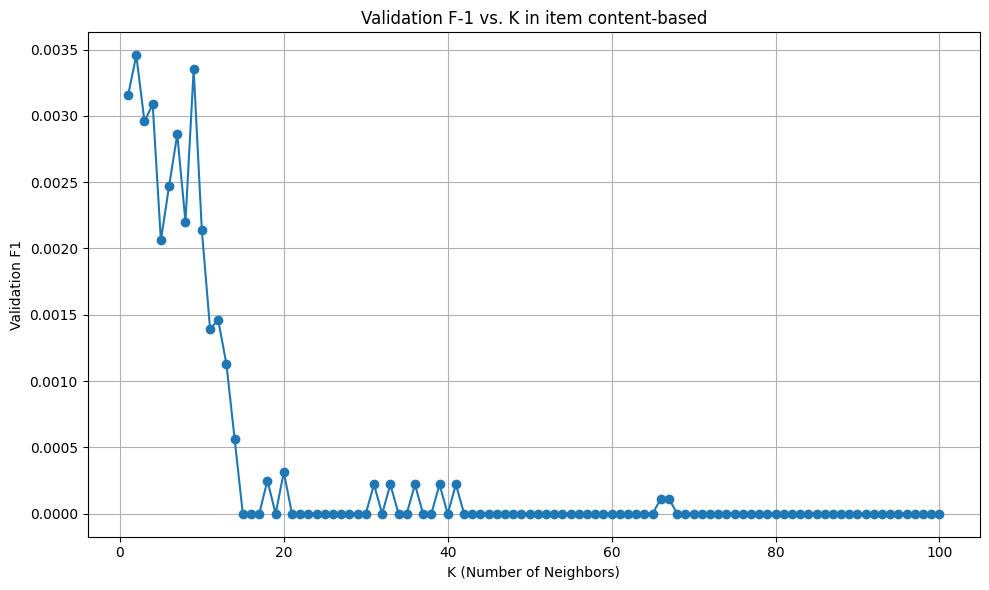

(2, 0.003456654441753491)

In [20]:
item_tuner = KTuner(val_matrix=validation_matrix, similarity_features=final_movie_df,
                    item_mapping=item_mapping, user_mapping=user_mapping, k_values=K_RANGE)

best_model, best_k, best_params = item_tuner.tune()
best_k, best_params

In [32]:
with open("../../models/content_based_item_knn_movie_lens.pkl", "wb") as f:
    pickle.dump(best_model, f)

# ItemKnn testing

The final accuracy metrics with the same hit on the **test dataset**:
- `accuracy`: 0.99
- `precision`: 0.002
- `recall`: 0.012 
- `f1`: 0.002

The test dataset is very sparse and unbalanced (most part of the pairs don't exist), so we again got into the **cold start** case 

In [21]:
item_accuracy_test = RankingMetricsEvaluator(matrix=test_matrix, model=best_model, user_mapping=user_mapping,item_mapping=item_mapping)

item_accuracy_test.summary()

Precision    0.001724
Recall       0.012007
F1           0.002827
Accuracy     0.994538
dtype: float64

Train the metrics calculator

In [22]:
item_test = TestMetricsCalculator(test_matrix=test_matrix, model=best_model, user_mapping=user_mapping,item_mapping=item_mapping, model_type='ranking')

INFO:root:Create top-10 recommendations' list
INFO:root:User: 0 -- top 10 list -- [608, 511, 256, 1818, 1977, 1447, 1241, 998, 2125, 994]
INFO:root:User: 1 -- top 10 list -- [1955, 1203, 1179, 110, 1575, 1288, 2086, 89, 1790, 1261]
INFO:root:User: 2 -- top 10 list -- [1126, 1701, 1003, 1294, 742, 743, 744, 745, 746, 754]
INFO:root:User: 3 -- top 10 list -- [1126, 206, 1241, 192, 1266, 1649, 847, 785, 734, 177]
INFO:root:User: 4 -- top 10 list -- [2048, 637, 1700, 1074, 951, 1470, 752, 751, 750, 749]
INFO:root:User: 5 -- top 10 list -- [1241, 206, 458, 880, 432, 584, 996, 1206, 161, 1790]
INFO:root:User: 6 -- top 10 list -- [155, 421, 840, 848, 161, 1010, 46, 380, 2253, 753]
INFO:root:User: 7 -- top 10 list -- [1126, 1701, 1211, 667, 1932, 2135, 767, 746, 750, 749]
INFO:root:User: 8 -- top 10 list -- [244, 730, 1700, 951, 952, 1748, 1254, 1688, 1544, 985]
INFO:root:User: 9 -- top 10 list -- [1266, 2231, 148, 1907, 1649, 1099, 1546, 1241, 206, 834]
INFO:root:User: 10 -- top 10 list -- [1

Final Conclusions about **content-based ItemKnn** with **MovieLens:
- The system demonstrates moderate relevance, with a Recovery score of ~0.49, indicating that relevant items appear somewhere in the top-N, but not consistently at the top.
- Despite this, the system fails to produce serendipitous recommendations, as the Serendipity (with relevance) score is 0.0, meaning no items are both unexpected and relevant at the same time.
- Inter-user diversity is low (~0.11), showing that recommendation lists are largely overlapping between users, which reduces personalization and discovery.
- Although the catalog coverage (0.29) is higher than in previous cases, it still means the system does not explore a large portion of the item catalog.
- The Item Space Coverage entropy is relatively high (24.69), which indicates that recommended items are used with moderate frequency diversity, even if the catalog itself isn’t well covered.
- Novelty is decent (0.62), which shows that the model includes a meaningful number of less popular items.
- The unexpectedness (0.59) confirms this: over half of the recommended items are less popular than the dataset average.

In [23]:
item_test.generate_metrics_summary_df()

,Metric,Area,Value,Value Range,Meaning
0,Recovery,Relevance,0.485714,"[0, 0.9]",How early relevant items appear in top-N recom...
1,Normalized AggDiv (diversity),Inter-user diversity,0.110888,"[0, 1]",Proportion of unique items recommended across ...
2,Normalized AggDiv (coverage),Coverage,0.293700,"[0, 1]",Proportion of unique items recommended across ...
3,Item Space Coverage,Coverage,24.685000,"[0, Not defined]",Shows how many unique items and how often appe...
4,Normalized ItemDeg,Novelty,0.622000,"[0, 1]",Novelty of recommended items based on inverse ...
5,Unexpectedness (no relevance),Serendipity,0.588000,"[0, 1]",Proportion of items that are unexpected (less ...
6,Serendipity (with relevance),Serendipity,0.000000,"[0, 1]",Proportion of unexpected and relevant items in...


The meanings of the metrics and their ranges

In [29]:
item_test.get_range_of_metrics()

,Metric,Min,Max,Explanation
0,Item space coverage,0,Not defined,small - recommendations focuses on several ite...
1,Recovery,0,0.9,0 - all the relevant items on the top of the l...
2,Normalized AggDiv (diversity),0,1,"0 - only 1 item was recommended for everyone, ..."
3,Normalized AggDiv (coverage),0,1,"0 - only 1 item was recommended, 1 - all the i..."
4,Unexpectedness (with_relevance=False),0,1,0 - there is no unexpected item (popularity be...
5,Serendipity (with_relevance=True),0,1,0 - there is no serendipitous item (popularity...
6,Normalized ItemDeg,0,1,0 - the most popular items are used (no novelt...


# UserKnn training

Tune with the paying attention to the **F1-score** on validation set - hit is the **presence of u-i in the validation matrix** which is present in **top N**

- The best **k: 88**
- The best F1: **0.009** (very low - algorithm don't cover the validation sets hits) 

INFO:root:Evaluating k=1...
INFO:root:F1 score @ top-10 for k=1: 0.0037
INFO:root:Evaluating k=2...
INFO:root:F1 score @ top-10 for k=2: 0.0035
INFO:root:Evaluating k=3...
INFO:root:F1 score @ top-10 for k=3: 0.0039
INFO:root:Evaluating k=4...
INFO:root:F1 score @ top-10 for k=4: 0.0047
INFO:root:Evaluating k=5...
INFO:root:F1 score @ top-10 for k=5: 0.0052
INFO:root:Evaluating k=6...
INFO:root:F1 score @ top-10 for k=6: 0.0047
INFO:root:Evaluating k=7...
INFO:root:F1 score @ top-10 for k=7: 0.0057
INFO:root:Evaluating k=8...
INFO:root:F1 score @ top-10 for k=8: 0.0064
INFO:root:Evaluating k=9...
INFO:root:F1 score @ top-10 for k=9: 0.0065
INFO:root:Evaluating k=10...
INFO:root:F1 score @ top-10 for k=10: 0.0062
INFO:root:Evaluating k=11...
INFO:root:F1 score @ top-10 for k=11: 0.0066
INFO:root:Evaluating k=12...
INFO:root:F1 score @ top-10 for k=12: 0.0067
INFO:root:Evaluating k=13...
INFO:root:F1 score @ top-10 for k=13: 0.0072
INFO:root:Evaluating k=14...
INFO:root:F1 score @ top-10

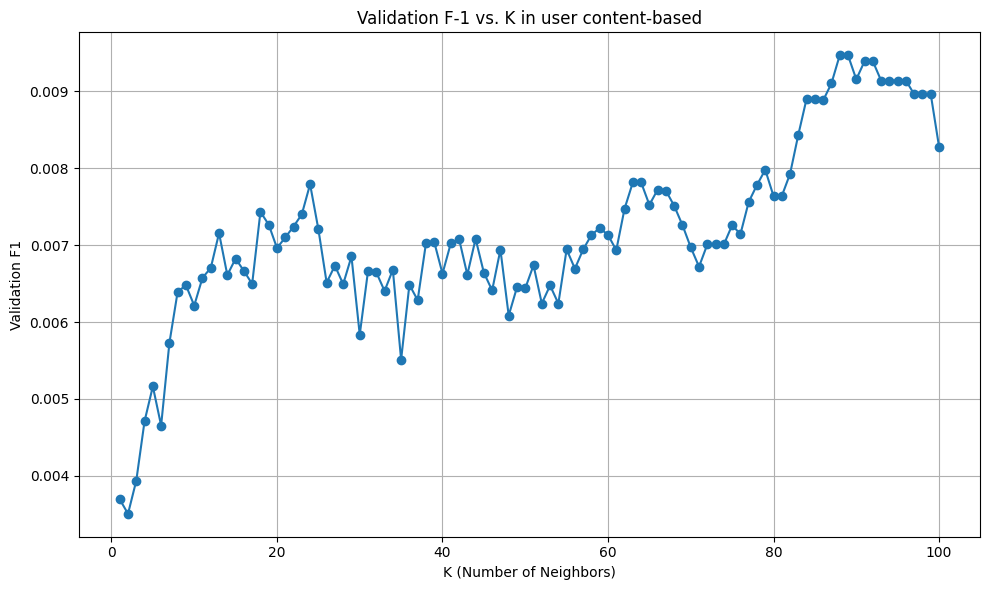

(88, 0.009471318678879294)

In [25]:
user_tuner = KTuner(val_matrix=validation_matrix, similarity_features=final_user_df,
                    item_mapping=item_mapping, user_mapping=user_mapping, k_values=K_RANGE, type='user')

user_best_model, user_best_k, user_best_params = user_tuner.tune()
user_best_k, user_best_params

In [33]:
with open("../../models/content_based_user_knn_movie_lens.pkl", "wb") as f:
    pickle.dump(user_best_model, f)

# UserKnn testing

The final accuracy metrics with the same hit on the **test dataset**:
- `accuracy`: 0.99
- `precision`: 0.003
- `recall`: 0.01
- `f1`: 0.003

The test dataset is very sparse and unbalanced (most part of the pairs don't exist), so we again got into the **cold start** case 

In [26]:
user_accuracy_test = RankingMetricsEvaluator(matrix=test_matrix, model=user_best_model, user_mapping=user_mapping,item_mapping=item_mapping)

user_accuracy_test.summary()

Precision    0.002217
Recall       0.009503
F1           0.003131
Accuracy     0.994543
dtype: float64

Train the metrics calculator

In [27]:
user_test = TestMetricsCalculator(test_matrix=test_matrix, model=user_best_model, user_mapping=user_mapping,item_mapping=item_mapping, model_type='ranking')

INFO:root:Create top-10 recommendations' list
INFO:root:User: 0 -- top 10 list -- [1667, 1639, 1572, 471, 534, 1851, 253, 571, 150, 145]
INFO:root:User: 1 -- top 10 list -- [587, 1667, 571, 1639, 1648, 425, 1003, 707, 1858, 686]
INFO:root:User: 2 -- top 10 list -- [1639, 1247, 210, 400, 660, 1156, 1234, 819, 145, 425]
INFO:root:User: 3 -- top 10 list -- [1639, 1247, 210, 400, 660, 1156, 1234, 819, 145, 425]
INFO:root:User: 4 -- top 10 list -- [434, 90, 1247, 1425, 261, 1190, 175, 488, 1548, 1256]
INFO:root:User: 5 -- top 10 list -- [434, 488, 90, 1247, 1256, 175, 261, 1190, 315, 157]
INFO:root:User: 6 -- top 10 list -- [434, 188, 1323, 352, 1648, 744, 135, 46, 877, 1549]
INFO:root:User: 7 -- top 10 list -- [90, 1855, 373, 877, 134, 1425, 174, 1256, 1696, 756]
INFO:root:User: 8 -- top 10 list -- [434, 188, 1323, 352, 1648, 744, 135, 46, 877, 1549]
INFO:root:User: 9 -- top 10 list -- [611, 434, 352, 944, 1197, 1181, 1237, 1869, 1648, 1426]
INFO:root:User: 10 -- top 10 list -- [1667, 471,

Final conclusions about **content-based UserKNN** with the MovieLens:
- The system achieves a moderate level of relevance, with a Recovery score of ~0.52, meaning relevant items appear closer to the middle of the top-N lists, but not consistently early.
- Serendipity (with relevance) remains at 0.0, confirming that while some unexpected items are recommended, none of them are relevant — again pointing to the issue of missing useful surprises.
- Inter-user diversity is extremely low (~0.025), suggesting that different users largely receive similar or overlapping recommendations, limiting personalization.
- The catalog coverage remains low (0.066), and although Item Space Coverage entropy (22.45) is moderately high, it indicates that while item usage is not fully skewed, overall exploration is shallow.
- Novelty (0.47) is moderate, implying that recommendations are a mix of popular and less popular items, though unexpectedness (0.44) shows nearly half the items are still below average in popularity.

In [28]:
user_test.generate_metrics_summary_df()

,Metric,Area,Value,Value Range,Meaning
0,Recovery,Relevance,0.521429,"[0, 0.9]",How early relevant items appear in top-N recom...
1,Normalized AggDiv (diversity),Inter-user diversity,0.025126,"[0, 1]",Proportion of unique items recommended across ...
2,Normalized AggDiv (coverage),Coverage,0.066548,"[0, 1]",Proportion of unique items recommended across ...
3,Item Space Coverage,Coverage,22.452000,"[0, Not defined]",Shows how many unique items and how often appe...
4,Normalized ItemDeg,Novelty,0.474000,"[0, 1]",Novelty of recommended items based on inverse ...
5,Unexpectedness (no relevance),Serendipity,0.437000,"[0, 1]",Proportion of items that are unexpected (less ...
6,Serendipity (with relevance),Serendipity,0.000000,"[0, 1]",Proportion of unexpected and relevant items in...


The meanings of the metrics and their ranges

In [30]:
user_test.get_range_of_metrics()

,Metric,Min,Max,Explanation
0,Item space coverage,0,Not defined,small - recommendations focuses on several ite...
1,Recovery,0,0.9,0 - all the relevant items on the top of the l...
2,Normalized AggDiv (diversity),0,1,"0 - only 1 item was recommended for everyone, ..."
3,Normalized AggDiv (coverage),0,1,"0 - only 1 item was recommended, 1 - all the i..."
4,Unexpectedness (with_relevance=False),0,1,0 - there is no unexpected item (popularity be...
5,Serendipity (with_relevance=True),0,1,0 - there is no serendipitous item (popularity...
6,Normalized ItemDeg,0,1,0 - the most popular items are used (no novelt...
